# Block Resampling & Z Scores

This code takes in raw climate data from [Met Eireann](http://www.met.ie/climate-request/) then: 
- Computes [Potential Evapotranspiration](https://en.wikipedia.org/wiki/Potential_evaporation) according to the Hargreaves method (chosen due to data availability) 
- Splits the data into seasons according to the climatological year (Winter: DJF, Spring: MAM, Summer: JJA, Autumn: SON)
- Removes seasons which has missing values above a user-defined threshold
- Calculates temperature and rainfall extremes based quantile ranking
- Allows for the selection of seasonal extremes (warm/wet, warm/dry, cold/wet, cold/dry)
- Resamples the observed climate and produces a new sequence which takes extremes into account

If you want to download this notebook you can use GitHub and [nbviewer](http://nbviewer.jupyter.org/)

### User-Defined Variables 

In [1]:
latitude = 51.93972 #input the latitude of your site location here (for calculating PE using the Hargreaves method)
#51.93972 is Valentia
#52.861 is Oak Park
upperlimit = 0.8 #this method uses quantiles, if this number is 0.9 the top 10% of data will be considered 'extreme' and so on
lowerlimit = 0.2

### Load Necessary Packages

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pyeto #install from here (https://github.com/woodcrafty/PyETo), download zip, move to scripts folder in your python
# distribution (/Anaconda/Scripts/PyETo), navigate to this folder in your cmd, type: python setup.py install, restart python
from pyeto import hargreaves
%matplotlib inline

### Read in & display climate data

Met Eireann Column Headers:
- maxtp: -  Maximum Air Temperature (C)
- mintp: -  Minimum  Air Temperature (C)
- rain: -	  Precipitation Amount (mm)
- cbl:  -   Mean CBL Pressure (hpa) (CBL - convective boundary layer)
- wdsp: -	  Mean Wind Speed (knot)
- hm: -	  Highest ten minute mean wind speed (knot)		                 
- ddhm: -	  Mean Wind Direction over 10 minutes at time of highest 10 minute mean (degree)                  
- hg: -	  Highest Gust (knot)
- soil  -   Mean 10cm soil temperature (C)
- i: -	  Indicator

Read in met data from different sites 

In [3]:
OakPark = pd.read_csv("E:\PhD\Data\MetData\Raw\dly375 (Oak Park)\dly375.csv",skiprows=16, na_values=[' '])
Valentia = pd.read_csv("E:\PhD\Data\MetData\Valentia\dly2275\dly2275.csv",skiprows=25, na_values=[' '])
Valentialong = pd.read_csv("E:\PhD\Data\MetData\Valentia\ValentiaObservatoryminmaxrain.csv")

In [4]:
df = Valentialong #load data into pandas dataframe
df.head()

,date,maxtp,mintp,rain
0,01/10/1939,15.3,6.7,0.0
1,02/10/1939,14.9,7.8,0.0
2,03/10/1939,14.3,7.3,0.0
3,04/10/1939,13.9,8.8,22.2
4,05/10/1939,16.8,11.1,25.6


Convert 'date' column to datetime object. Table below describes notation:

  Directive     | Meaning       | Example      |
  ------------- | ------------- | ------------ |
  %d            | Day of the month as a zero-padded decimal number | 01, 02, ..., 31 
  %b  | Month as locale’s abbreviated name  |    Jan, Feb, ..., Dec (en_US)
  %B | Month as locale’s full name | January, February, ..., December (en_US)
  %m | 	Month as a zero-padded decimal number | 01, 02, ..., 12
  %y | 	Year without century as a zero-padded decimal number |	00, 01, ..., 99
  %Y | Year with century as a decimal number | 1970, 1988, 2001, 2013
  


In [5]:
# df['date'] = pd.to_datetime(df['date'], format= '%d-%b-%Y') # Works for Oak Park

df['date'] = pd.to_datetime(df['date'], format= '%d/%m/%Y') #works for Valentialong

#https://docs.python.org/2/library/datetime.html see end of this page for details on date notation

Find start and end year of the data

In [6]:
no_of_years = df['date'].dt.year #creates a variable for the year column
no_of_years = list(no_of_years) #turns it into a list

In [7]:
startyear = no_of_years[0] #gets the first value
print startyear

endyear = no_of_years[-1] #gets the last value
print endyear

1939
2010


### Create mean temp field from max and min

In [8]:
df['meantp'] = (df['maxtp'] + df['mintp'])/2
df.meantp = df.meantp.round(1) #keep Tmean to one decimal place as that's what's in the original dat
#NOTE:Numpy rounds to the nearest even value. Thus 1.5 and 2.5 round to 2.0, -0.5 and 0.5 round to 0.0, 1.55 rounds to 1.5, -1.55 rounds to -1.5.

### Calculate PET using [Hargreaves method](https://github.com/woodcrafty/PyETo/blob/master/docs/hargreaves.rst) (from [PyETo package](https://github.com/woodcrafty/PyETo))

The hargreaves method is recommended by the FAO (Allen et al, 1998) where insufficient meterological data are available from Penman-Monteith)

It uses temperature and solar radiation which is estimated from the latitude and the time of year.

The Hargreaves equation has a tendency to under-estimate ETo under high wind conditions(u2 > 3m/s) and to over-estimate under conditions of high relative humidity.

(Info taken from [here](https://github.com/woodcrafty/PyETo/blob/master/docs/hargreaves.rst))

**First specify latitude for your site, and create a 'day of year' column from the date:**

In [9]:
lat = pyeto.deg2rad(latitude) #latitude for site

df['lat']= lat #add column to the dataframe

df['dayofyear'] = pd.DatetimeIndex(df['date']).dayofyear #create 'day of year' column to calculate sunshine variables

Estimate solar declination (sol_dec), sunset hour angle (sha), inverse relative distance from Earth to the sun (ird), and ET radiation (et_rad)

In [10]:
sol_dec = df['dayofyear'].apply(pyeto.sol_dec)   # Solar declination
df['sol_dec'] = sol_dec #add column

sha = df.apply(lambda x: pyeto.sunset_hour_angle(x['lat'],x['sol_dec']), axis=1)
df['sha'] = sha #add column

ird = df['dayofyear'].apply(pyeto.inv_rel_dist_earth_sun)
df['ird'] = ird

et_rad = df.apply(lambda x: pyeto.et_rad(x['lat'],x['sol_dec'],x['sha'],x['ird']), axis =1)   # Extraterrestrial radiation
df['et_rad'] = et_rad

df.head()

,date,maxtp,mintp,rain,meantp,lat,dayofyear,sol_dec,sha,ird,et_rad
0,1939-10-01,15.3,6.7,0.0,11.0,0.906519,274,-0.075274,1.474327,1.000142,19.719981
1,1939-10-02,14.9,7.8,0.0,11.4,0.906519,275,-0.082183,1.465403,1.000710,19.418836
2,1939-10-03,14.3,7.3,0.0,10.8,0.906519,276,-0.089068,1.456491,1.001278,19.119337
3,1939-10-04,13.9,8.8,22.2,11.4,0.906519,277,-0.095926,1.447594,1.001845,18.821587
4,1939-10-05,16.8,11.1,25.6,14.0,0.906519,278,-0.102755,1.438713,1.002412,18.525685


Apply the 'hargreaves' function

In [11]:
PEcalc = df.apply(lambda x: hargreaves(x['mintp'], x['maxtp'], x['meantp'], x['et_rad']),axis=1)
df['hargreaves'] = PEcalc #create a column
df.head()

,date,maxtp,mintp,rain,meantp,lat,dayofyear,sol_dec,sha,ird,et_rad,hargreaves
0,1939-10-01,15.3,6.7,0.0,11.0,0.906519,274,-0.075274,1.474327,1.000142,19.719981,1.562918
1,1939-10-02,14.9,7.8,0.0,11.4,0.906519,275,-0.082183,1.465403,1.000710,19.418836,1.417827
2,1939-10-03,14.3,7.3,0.0,10.8,0.906519,276,-0.089068,1.456491,1.001278,19.119337,1.357613
3,1939-10-04,13.9,8.8,22.2,11.4,0.906519,277,-0.095926,1.447594,1.001845,18.821587,1.164695
4,1939-10-05,16.8,11.1,25.6,14.0,0.906519,278,-0.102755,1.438713,1.002412,18.525685,1.319857


Compare hargreaves calculation to Met Eireann PE (Penman-Monteith method) (purely to see if the calculation approximates)

In [12]:
metPE = pd.read_excel("E:\PhD\Data\MetData\PE\OakPark 08-16.xlsx")
metPE['date'] = pd.to_datetime(metPE['date'], format= '%d-%b-%Y') #datetime object
metPE = metPE[['date','PE (mm)']]
metPE.head()

,date,PE (mm)
0,2008-01-01,0.546
1,2008-01-02,0.825
2,2008-01-03,0.416
3,2008-01-04,0.390
4,2008-01-05,0.253


Drop 2007 from hargreaves calculation

In [13]:
df2 = df.ix[365:]
df2 = df2[['date','hargreaves']]
df2.head()

,date,hargreaves
365,1940-09-30,1.464971
366,1940-10-01,1.168623
367,1940-10-02,1.143864
368,1940-10-03,1.284066
369,1940-10-04,1.286011


Merge the two dataframes

**Calculate seasonal sums and compare (percentage bias)**

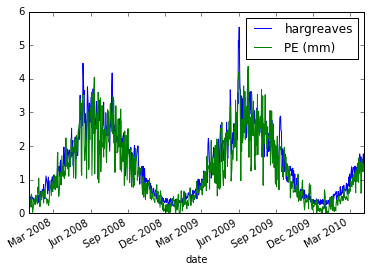

In [14]:
compare = df2.merge(metPE, on = 'date')
compare.to_csv('E:\PhD\Data\Block Resampling\PEcomparison.csv', sep = ',')
compare.plot(x='date')

Filter out unwanted columns (Model only needs temp, PE and rainfall)

In [15]:
df.drop(df.columns[[1, 2, 5, 6, 7, 8, 9, 10]], axis=1, inplace=True)
cols = df.columns.tolist()
cols = ['date', 'meantp', 'hargreaves', 'rain']
df = df.ix[:, cols]
df.head()

,date,meantp,hargreaves,rain
0,1939-10-01,11.0,1.562918,0.0
1,1939-10-02,11.4,1.417827,0.0
2,1939-10-03,10.8,1.357613,0.0
3,1939-10-04,11.4,1.164695,22.2
4,1939-10-05,14.0,1.319857,25.6


Convert 'date' column to datetime object so Pandas can use it 

Split data into seasons based on months

Winter = 1, Spring = 2, Summer = 3, Autumn = 4

In [16]:
#create a season function to split data into seasons
def get_season(row):
    if row['date'].month >= 3 and row['date'].month <= 5:
        return '2'
    elif row['date'].month >= 6 and row['date'].month <= 8:
        return '3'
    elif row['date'].month >= 9 and row['date'].month <= 11:
        return '4'
    else:
        return '1'

Apply the season function to the data

In [17]:
df['Season'] = df.apply(get_season, axis=1)

Create 'Year' column from the 'date' column

In [18]:
df['Year'] = df['date'].dt.year
df.head()

,date,meantp,hargreaves,rain,Season,Year
0,1939-10-01,11.0,1.562918,0.0,4,1939
1,1939-10-02,11.4,1.417827,0.0,4,1939
2,1939-10-03,10.8,1.357613,0.0,4,1939
3,1939-10-04,11.4,1.164695,22.2,4,1939
4,1939-10-05,14.0,1.319857,25.6,4,1939


Make December of previous year part of winter for current year (to keep climatolgical year) 

In [19]:
#Redefine the year to attach December of previous year to winter of following year 
#Everywhere the month is '12', the year column gets increased by 1. 
df.loc[df['date'].dt.month == 12, 'Year'] += 1
df.head()

,date,meantp,hargreaves,rain,Season,Year
0,1939-10-01,11.0,1.562918,0.0,4,1939
1,1939-10-02,11.4,1.417827,0.0,4,1939
2,1939-10-03,10.8,1.357613,0.0,4,1939
3,1939-10-04,11.4,1.164695,22.2,4,1939
4,1939-10-05,14.0,1.319857,25.6,4,1939


Create a new dataframe indexed by Year and Season

In [20]:
#how to multiindex from here: http://stackoverflow.com/questions/33435971/selecting-time-series-data-in-a-specific-sequence-using-pandas/33437422#33437422
df2 = df.set_index(['Year', 'Season'], inplace=False)
df2.head()

date  meantp  hargreaves  rain
Year Season                                     
1939 4      1939-10-01    11.0    1.562918   0.0
     4      1939-10-02    11.4    1.417827   0.0
     4      1939-10-03    10.8    1.357613   0.0
     4      1939-10-04    11.4    1.164695  22.2
     4      1939-10-05    14.0    1.319857  25.6

# Remove incomplete seasons and apply missing value threshold
Count the values in each season (also indicates missing values)

Number of days in:
- 1 (Winter): 90 (91 in Leap Year - how to deal with this?) 
- 2 (Spring): 92
- 3 (Summer): 92
- 4 (Autumn): 91

In [21]:
count = df2.groupby(level=[0, 1]).count()
count

date  meantp  hargreaves  rain
Year Season                                
1939 4         61      61          61    61
1940 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1941 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1942 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1943 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1944 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1945 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1946 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1947 1         90      90          90    90
...           ...     ...         ...   ...
2003 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2004 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2005 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2006 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2007 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2008 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2009 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2010 1         90      90          90    90
     2         36      36          36    36

[283 rows x 4 columns]

Create a 'complete' variable with only complete months of data (75 is completely arbitrary - code this in up top)

In [22]:
complete = count[count['rain'] >= 75].index #counts seasons with more than 75 values for rain

Create an index for the values in the dataframe which match the 'complete' index

In [23]:
idx = df2.index.isin(complete)
idx #first are false, as the first season (Winter 2007) does not have enough days in it (missing December 2006)

array([False, False, False, ..., False, False, False], dtype=bool)

In [24]:
df = df[idx]
df

,date,meantp,hargreaves,rain,Season,Year
61,1939-12-01,11.5,0.401188,13.1,1,1940
62,1939-12-02,8.6,0.291802,4.1,1,1940
63,1939-12-03,7.4,0.432507,11.0,1,1940
64,1939-12-04,6.6,0.327173,10.8,1,1940
65,1939-12-05,8.1,0.323264,4.4,1,1940
66,1939-12-06,5.6,0.422446,0.0,1,1940
67,1939-12-07,10.1,0.392275,18.6,1,1940
68,1939-12-08,8.6,0.371815,9.1,1,1940
69,1939-12-09,11.6,0.340415,22.9,1,1940
70,1939-12-10,8.9,0.284215,4.8,1,1940


In [25]:
df2 = df.set_index(['Year', 'Season'], inplace=False)
df2

date  meantp  hargreaves  rain
Year Season                                     
1940 1      1939-12-01    11.5    0.401188  13.1
     1      1939-12-02     8.6    0.291802   4.1
     1      1939-12-03     7.4    0.432507  11.0
     1      1939-12-04     6.6    0.327173  10.8
     1      1939-12-05     8.1    0.323264   4.4
     1      1939-12-06     5.6    0.422446   0.0
     1      1939-12-07    10.1    0.392275  18.6
     1      1939-12-08     8.6    0.371815   9.1
     1      1939-12-09    11.6    0.340415  22.9
     1      1939-12-10     8.9    0.284215   4.8
     1      1939-12-11     7.7    0.303542   0.4
     1      1939-12-12     4.9    0.362009   0.0
     1      1939-12-13     8.6    0.271535  14.8
     1      1939-12-14     5.3    0.328671   0.7
     1      1939-12-15     3.5    0.332661   0.2
     1      1939-12-16     4.6    0.296012   0.0
     1      1939-12-17     2.0    0.281481   0.0
     1      1939-12-18     1.6    0.244583   0.0
     1      1939-12-19     2.8    0.189431   0.0
     1      1939-12-20     2.5    0.373132   0.0
     1      1939-12-21     6.9    0.293091   0.6
     1      1939-12-22     3.2    0.350464   0.0
     1      1939-12-23     1.4    0.328910   0.0
     1      1939-12-24     1.4    0.350766   0.1
     1      1939-12-25     2.5    0.371892   0.0
     1      1939-12-26     3.1    0.404121   0.2
     1      1939-12-27     5.6    0.359166   1.0
     1      1939-12-28     7.5    0.298325   0.1
     1      1939-12-29     5.2    0.315880   0.0
     1      1939-12-30     9.1    0.265371   0.0
...                ...     ...         ...   ...
2010 1      2010-01-30     4.6    0.505385   0.7
     1      2010-01-31     3.6    0.499839   2.0
     1      2010-02-01     4.0    0.647020   1.8
     1      2010-02-02     9.0    0.423748   2.6
     1      2010-02-03     8.6    0.571556   3.9
     1      2010-02-04     8.8    0.547806  20.5
     1      2010-02-05     7.5    0.510898  16.2
     1      2010-02-06     6.6    0.789336   0.0
     1      2010-02-07     8.4    0.541637   0.0
     1      2010-02-08     5.0    0.606279   0.0
     1      2010-02-09     3.6    0.538912   0.0
     1      2010-02-10     2.9    0.665028   0.0
     1      2010-02-11     2.4    0.716539   0.0
     1      2010-02-12     2.9    0.790457   0.0
     1      2010-02-13     3.8    0.591213   0.0
     1      2010-02-14     3.2    0.811830   0.0
     1      2010-02-15     4.8    0.829945   1.6
     1      2010-02-16     5.0    0.731335   2.8
     1      2010-02-17     4.4    0.684328   0.0
     1      2010-02-18     4.4    0.696812   0.5
     1      2010-02-19     3.6    0.659468   5.8
     1      2010-02-20     2.8    0.710197   3.0
     1      2010-02-21     2.8    0.890051   0.0
     1      2010-02-22     2.4    0.883785   0.0
     1      2010-02-23     3.4    0.545034   1.4
     1      2010-02-24     5.4    0.703624   0.5
     1      2010-02-25     3.6    0.854585   0.5
     1      2010-02-26     5.0    0.816977   0.3
     1      2010-02-27     4.5    1.075354   1.7
     1      2010-02-28     6.1    0.954742   2.4

[25658 rows x 4 columns]

Calculate number of seasons in the dataset (to calculate seasonal rainfall means later)

In [26]:
seascount = df2.groupby(level=[0,1]).count() #counting number of seasons (to divide for avg seasonal rainfall later)
seascount

date  meantp  hargreaves  rain
Year Season                                
1940 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1941 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1942 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1943 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1944 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1945 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1946 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
1947 1         90      90          90    90
     2         92      92          92    92
...           ...     ...         ...   ...
2002 4         91      91          91    91
2003 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2004 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2005 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2006 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2007 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2008 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2009 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2010 1         90      90          90    90

[281 rows x 4 columns]

In [27]:
seasoncount = df.reset_index().groupby('Season')['Year'].nunique()
print seasoncount

Season
1    71
2    70
3    70
4    70
Name: Year, dtype: int64


# Temperature Extremes

Calculate mean values for each season

In [28]:
seasmean = df['meantp'].groupby(df['Season']).mean()
print seasmean #check the averages - do they seem correct? Yes

Season
1     7.202965
2     9.485854
3    14.512857
4    11.464082
Name: meantp, dtype: float64


Calculating differences between each season overall season means

In [29]:
df2['seasdif'] = df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean #creates an anomaly column
seasdif = df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean #creates a series
seasdif

Year  Season
1940  1        -0.672196
      2         0.638059
      3         0.312143
      4        -0.378367
1941  1        -1.067409
      2        -1.181506
      3        -0.205248
      4         0.407347
1942  1         0.021479
      2         0.734798
      3         0.023012
      4        -1.554192
1943  1         1.509257
      2         0.632624
      3        -0.010683
      4        -0.343203
1944  1         0.288244
      2         0.305450
      3         0.481708
      4        -0.649796
1945  1        -0.230743
      2         1.232624
      3         0.276273
      4         1.390863
1946  1         0.917035
      2         0.146755
      3        -1.084596
      4         0.405149
1947  1        -1.985187
      2        -0.529332
                  ...   
2002  4         0.417237
2003  1         0.430368
      2         0.952189
      3         0.618665
      4         0.290863
2004  1         0.494837
      2         0.357624
      3         0.224099
      4     

# Rainfall Extremes

Calculate sum values for each season

In [30]:
rainsum = df['rain'].groupby(df['Season']).sum() / seasoncount #seasonal sums divided by number of years to get baseline rainfall
print rainsum #checked this in Excel, the division is correct

Season
1    451.521127
2    289.891429
3    283.628571
4    442.672857
dtype: float64


In [31]:
raindif = df2['rain'].groupby(level=['Year','Season']).sum() - rainsum #work out the anomalies
raindif

Year  Season
1940  1           8.778873
      2         -82.391429
      3        -151.728571
      4          50.627143
1941  1          39.178873
      2         -42.091429
      3         -81.428571
      4         -51.172857
1942  1         -60.721127
      2          86.708571
      3         -79.928571
      4        -223.472857
1943  1         -15.121127
      2         -48.591429
      3          60.071429
      4          25.927143
1944  1        -174.421127
      2        -133.991429
      3         -41.128571
      4          35.127143
1945  1          17.778873
      2         -43.791429
      3          49.771429
      4        -107.772857
1946  1          77.778873
      2         -77.291429
      3          73.771429
      4          62.027143
1947  1          93.978873
      2         113.608571
                   ...    
2002  4         205.827143
2003  1         -12.221127
      2          67.608571
      3          22.471429
      4         -28.572857
2004  1        

# Extracting extreme seasons

Create a copy of the dataframe and two blank lists for hot and cold extremes

In [32]:
seasdif2 = pd.DataFrame(seasdif)
raindif2 = pd.DataFrame(raindif)
warm = []
cold = []
seasdif2['rain'] = raindif2[0] #add the rain anomaly column to seasdif2
seasdif2

meantp        rain
Year Season                      
1940 1      -0.672196    8.778873
     2       0.638059  -82.391429
     3       0.312143 -151.728571
     4      -0.378367   50.627143
1941 1      -1.067409   39.178873
     2      -1.181506  -42.091429
     3      -0.205248  -81.428571
     4       0.407347  -51.172857
1942 1       0.021479  -60.721127
     2       0.734798   86.708571
     3       0.023012  -79.928571
     4      -1.554192 -223.472857
1943 1       1.509257  -15.121127
     2       0.632624  -48.591429
     3      -0.010683   60.071429
     4      -0.343203   25.927143
1944 1       0.288244 -174.421127
     2       0.305450 -133.991429
     3       0.481708  -41.128571
     4      -0.649796   35.127143
1945 1      -0.230743   17.778873
     2       1.232624  -43.791429
     3       0.276273   49.771429
     4       1.390863 -107.772857
1946 1       0.917035   77.778873
     2       0.146755  -77.291429
     3      -1.084596   73.771429
     4       0.405149   62.027143
1947 1      -1.985187   93.978873
     2      -0.529332  113.608571
...               ...         ...
2002 4       0.417237  205.827143
2003 1       0.430368  -12.221127
     2       0.952189   67.608571
     3       0.618665   22.471429
     4       0.290863  -28.572857
2004 1       0.494837  -60.821127
     2       0.357624    1.008571
     3       0.224099   14.371429
     4       0.307347   -0.472857
2005 1       1.028146  -63.621127
     2       0.480450   88.808571
     3       0.737143  -27.928571
     4       0.820534   -6.772857
2006 1       0.681479  -67.321127
     2      -0.315202  150.308571
     3       0.870839  -82.128571
     4       1.372182  221.227143
2007 1       1.372591   85.078873
     2       0.848929  -51.391429
     3       0.365404   50.271429
     4       1.262292 -165.272857
2008 1       1.665167  125.378873
     2       0.707624   28.408571
     3       0.250186  138.671429
     4      -0.266279    0.527143
2009 1       0.257035   -1.521127
     2       0.655450   63.108571
     3       0.488230  336.071429
     4       0.616138  215.627143
2010 1      -1.989632  -25.821127

[281 rows x 2 columns]

### [Quantiles/ Percentiles](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.quantile.html)
(works in the same was as [numpy.percentile](http://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html))

In [33]:
seasdif2['warm'] = 0 #add a blank column for warm
seasdif2['cold'] = 0 #add a blank column for cold
seasdif2['wet'] = 0 #add a blank column for wet
seasdif2['dry'] = 0 #add a blank column for dry

In [34]:
seasdif2.loc[seasdif2['meantp'] > seasdif2['meantp'].quantile(upperlimit), 'warm'] = 1 # adds 1 for hot percentile
seasdif2.loc[seasdif2['meantp'] < seasdif2['meantp'].quantile(lowerlimit), 'cold'] = 1 # adds 1 for cold percentile 

seasdif2.loc[seasdif2['rain'] > seasdif2['rain'].quantile(upperlimit), 'wet'] = 1 #adds a 1 for wet percentile
seasdif2.loc[seasdif2['rain'] < seasdif2['rain'].quantile(lowerlimit), 'dry'] = 1 #adds a 1 for dry percentile

seasdif2

meantp        rain  warm  cold  wet  dry
Year Season                                            
1940 1      -0.672196    8.778873     0     1    0    0
     2       0.638059  -82.391429     0     0    0    1
     3       0.312143 -151.728571     0     0    0    1
     4      -0.378367   50.627143     0     0    0    0
1941 1      -1.067409   39.178873     0     1    0    0
     2      -1.181506  -42.091429     0     1    0    0
     3      -0.205248  -81.428571     0     0    0    1
     4       0.407347  -51.172857     0     0    0    0
1942 1       0.021479  -60.721127     0     0    0    0
     2       0.734798   86.708571     1     0    1    0
     3       0.023012  -79.928571     0     0    0    0
     4      -1.554192 -223.472857     0     1    0    1
1943 1       1.509257  -15.121127     1     0    0    0
     2       0.632624  -48.591429     0     0    0    0
     3      -0.010683   60.071429     0     0    0    0
     4      -0.343203   25.927143     0     0    0    0
1944 1       0.288244 -174.421127     0     0    0    1
     2       0.305450 -133.991429     0     0    0    1
     3       0.481708  -41.128571     0     0    0    0
     4      -0.649796   35.127143     0     1    0    0
1945 1      -0.230743   17.778873     0     0    0    0
     2       1.232624  -43.791429     1     0    0    0
     3       0.276273   49.771429     0     0    0    0
     4       1.390863 -107.772857     1     0    0    1
1946 1       0.917035   77.778873     1     0    0    0
     2       0.146755  -77.291429     0     0    0    0
     3      -1.084596   73.771429     0     1    0    0
     4       0.405149   62.027143     0     0    0    0
1947 1      -1.985187   93.978873     0     1    1    0
     2      -0.529332  113.608571     0     0    1    0
...               ...         ...   ...   ...  ...  ...
2002 4       0.417237  205.827143     0     0    1    0
2003 1       0.430368  -12.221127     0     0    0    0
     2       0.952189   67.608571     1     0    0    0
     3       0.618665   22.471429     0     0    0    0
     4       0.290863  -28.572857     0     0    0    0
2004 1       0.494837  -60.821127     0     0    0    0
     2       0.357624    1.008571     0     0    0    0
     3       0.224099   14.371429     0     0    0    0
     4       0.307347   -0.472857     0     0    0    0
2005 1       1.028146  -63.621127     1     0    0    0
     2       0.480450   88.808571     0     0    1    0
     3       0.737143  -27.928571     1     0    0    0
     4       0.820534   -6.772857     1     0    0    0
2006 1       0.681479  -67.321127     1     0    0    0
     2      -0.315202  150.308571     0     0    1    0
     3       0.870839  -82.128571     1     0    0    1
     4       1.372182  221.227143     1     0    1    0
2007 1       1.372591   85.078873     1     0    1    0
     2       0.848929  -51.391429     1     0    0    0
     3       0.365404   50.271429     0     0    0    0
     4       1.262292 -165.272857     1     0    0    1
2008 1       1.665167  125.378873     1     0    1    0
     2       0.707624   28.408571     1     0    0    0
     3       0.250186  138.671429     0     0    1    0
     4      -0.266279    0.527143     0     0    0    0
2009 1       0.257035   -1.521127     0     0    0    0
     2       0.655450   63.108571     0     0    0    0
     3       0.488230  336.071429     0     0    1    0
     4       0.616138  215.627143     0     0    1    0
2010 1      -1.989632  -25.821127     0     1    0    0

[281 rows x 6 columns]

In [35]:
extremecount = seasdif2[['warm','cold','wet','dry']]
extremecount

warm  cold  wet  dry
Year Season                      
1940 1          0     1    0    0
     2          0     0    0    1
     3          0     0    0    1
     4          0     0    0    0
1941 1          0     1    0    0
     2          0     1    0    0
     3          0     0    0    1
     4          0     0    0    0
1942 1          0     0    0    0
     2          1     0    1    0
     3          0     0    0    0
     4          0     1    0    1
1943 1          1     0    0    0
     2          0     0    0    0
     3          0     0    0    0
     4          0     0    0    0
1944 1          0     0    0    1
     2          0     0    0    1
     3          0     0    0    0
     4          0     1    0    0
1945 1          0     0    0    0
     2          1     0    0    0
     3          0     0    0    0
     4          1     0    0    1
1946 1          1     0    0    0
     2          0     0    0    0
     3          0     1    0    0
     4          0     0    0    0
1947 1          0     1    1    0
     2          0     0    1    0
...           ...   ...  ...  ...
2002 4          0     0    1    0
2003 1          0     0    0    0
     2          1     0    0    0
     3          0     0    0    0
     4          0     0    0    0
2004 1          0     0    0    0
     2          0     0    0    0
     3          0     0    0    0
     4          0     0    0    0
2005 1          1     0    0    0
     2          0     0    1    0
     3          1     0    0    0
     4          1     0    0    0
2006 1          1     0    0    0
     2          0     0    1    0
     3          1     0    0    1
     4          1     0    1    0
2007 1          1     0    1    0
     2          1     0    0    0
     3          0     0    0    0
     4          1     0    0    1
2008 1          1     0    1    0
     2          1     0    0    0
     3          0     0    1    0
     4          0     0    0    0
2009 1          0     0    0    0
     2          0     0    0    0
     3          0     0    1    0
     4          0     0    1    0
2010 1          0     1    0    0

[281 rows x 4 columns]

### Select out combinations of extremes (warm/wet, warm/dry, cold/wet, cold/dry)

In [36]:
#identify columns with  extremes
extremeseasons = seasdif2.loc[(seasdif2.cold==1) | (seasdif2.dry==1) | (seasdif2.warm==1) | (seasdif2.wet ==1)]
extremeseasons

meantp        rain  warm  cold  wet  dry
Year Season                                            
1940 1      -0.672196    8.778873     0     1    0    0
     2       0.638059  -82.391429     0     0    0    1
     3       0.312143 -151.728571     0     0    0    1
1941 1      -1.067409   39.178873     0     1    0    0
     2      -1.181506  -42.091429     0     1    0    0
     3      -0.205248  -81.428571     0     0    0    1
1942 2       0.734798   86.708571     1     0    1    0
     4      -1.554192 -223.472857     0     1    0    1
1943 1       1.509257  -15.121127     1     0    0    0
1944 1       0.288244 -174.421127     0     0    0    1
     2       0.305450 -133.991429     0     0    0    1
     4      -0.649796   35.127143     0     1    0    0
1945 2       1.232624  -43.791429     1     0    0    0
     4       1.390863 -107.772857     1     0    0    1
1946 1       0.917035   77.778873     1     0    0    0
     3      -1.084596   73.771429     0     1    0    0
1947 1      -1.985187   93.978873     0     1    1    0
     2      -0.529332  113.608571     0     0    1    0
     4       0.740314  -77.872857     1     0    0    0
1948 2       0.771755  -53.391429     1     0    0    0
     4       0.751303  -47.872857     1     0    0    0
1949 1       1.413702  -10.221127     1     0    0    0
     2       0.245668  -81.591429     0     0    0    1
     3       0.882795  -23.428571     1     0    0    0
     4       1.095259  105.027143     1     0    1    0
1950 2       0.721755 -101.691429     1     0    0    1
     3       0.106708  170.771429     0     0    1    0
     4      -1.005840   42.827143     0     1    0    0
1951 1      -1.702965    9.578873     0     1    0    0
     2      -1.094550  -53.191429     0     1    0    0
...               ...         ...   ...   ...  ...  ...
1998 1       1.020368  -26.021127     1     0    0    0
     3      -0.093292  134.771429     0     0    1    0
     4       0.839215   99.027143     1     0    1    0
1999 1       1.079257   52.478873     1     0    0    0
     2       0.692407   64.108571     1     0    0    0
     4       0.302951   86.727143     0     0    1    0
2000 1       0.237694  153.978873     0     0    1    0
     4      -0.476170  288.427143     0     0    1    0
2001 4       0.946907  -90.172857     1     0    0    1
2002 1       1.042591   83.378873     1     0    1    0
     3      -0.813944   31.171429     0     1    0    0
     4       0.417237  205.827143     0     0    1    0
2003 2       0.952189   67.608571     1     0    0    0
2005 1       1.028146  -63.621127     1     0    0    0
     2       0.480450   88.808571     0     0    1    0
     3       0.737143  -27.928571     1     0    0    0
     4       0.820534   -6.772857     1     0    0    0
2006 1       0.681479  -67.321127     1     0    0    0
     2      -0.315202  150.308571     0     0    1    0
     3       0.870839  -82.128571     1     0    0    1
     4       1.372182  221.227143     1     0    1    0
2007 1       1.372591   85.078873     1     0    1    0
     2       0.848929  -51.391429     1     0    0    0
     4       1.262292 -165.272857     1     0    0    1
2008 1       1.665167  125.378873     1     0    1    0
     2       0.707624   28.408571     1     0    0    0
     3       0.250186  138.671429     0     0    1    0
2009 3       0.488230  336.071429     0     0    1    0
     4       0.616138  215.627143     0     0    1    0
2010 1      -1.989632  -25.821127     0     1    0    0

[173 rows x 6 columns]

Create new index for extremes

In [37]:
df2.index.tolist()

[(1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '1'),
 (1940L, '

Count extreme values in each year

In [38]:
extremecount = seasdif2.groupby(level=[0]).sum()
extremecount

,meantp,rain,warm,cold,wet,dry
Year,,,,,,
1940,-0.100361,-174.713984,0,1,0,2
1941,-2.046817,-135.513984,0,2,0,1
1942,-0.774902,-277.413984,1,1,1,1
1943,1.787996,22.286016,1,0,0,0
1944,0.425606,-314.413984,0,1,0,2
1945,2.669018,-84.013984,2,0,0,1
1946,0.384342,136.286016,1,1,0,0
1947,-1.228367,71.986016,1,1,2,0
1948,1.242508,-84.913984,2,0,0,0


## Plot frequency of extremes

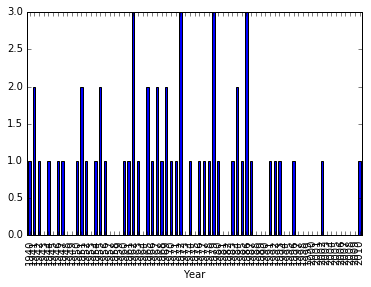

In [39]:
extremecount['cold'].plot(kind='bar')

### View combinations of extremes

In [40]:
seasdif2.loc[(seasdif2.warm==1) & (seasdif2.wet ==1)]

,,meantp,rain,warm,cold,wet,dry
Year,Season,,,,,,
1942,2,0.734798,86.708571,1,0,1,0
1949,4,1.095259,105.027143,1,0,1,0
1968,4,0.778776,101.527143,1,0,1,0
1992,2,0.839146,87.808571,1,0,1,0
1994,1,0.665924,165.078873,1,0,1,0
1995,1,1.029257,233.878873,1,0,1,0
1997,3,0.741491,95.971429,1,0,1,0
1998,4,0.839215,99.027143,1,0,1,0
2002,1,1.042591,83.378873,1,0,1,0


warm/dry

In [41]:
seasdif2.loc[(seasdif2.warm==1) & (seasdif2.dry ==1)]

,,meantp,rain,warm,cold,wet,dry
Year,Season,,,,,,
1945,4,1.390863,-107.772857,1,0,0,1
1950,2,0.721755,-101.691429,1,0,0,1
1955,3,1.336056,-149.328571,1,0,0,1
1971,4,1.078776,-134.272857,1,0,0,1
1975,3,0.704534,-150.028571,1,0,0,1
1976,3,1.132795,-82.028571,1,0,0,1
1978,4,1.016138,-175.572857,1,0,0,1
1981,1,0.701479,-87.221127,1,0,0,1
1983,3,1.123012,-100.128571,1,0,0,1


cold/dry

In [42]:
seasdif2.loc[(seasdif2.cold==1) & (seasdif2.dry==1)]

,,meantp,rain,warm,cold,wet,dry
Year,Season,,,,,,
1942,4,-1.554192,-223.472857,0,1,0,1
1952,4,-0.973972,-120.972857,0,1,0,1
1961,3,-0.676988,-83.728571,0,1,0,1
1962,4,-0.808038,-104.472857,0,1,0,1
1963,1,-2.534076,-171.321127,0,1,0,1
1965,1,-1.390743,-85.721127,0,1,0,1
1966,4,-0.781664,-117.172857,0,1,0,1
1969,2,-0.823898,-130.791429,0,1,0,1
1971,2,-0.819550,-113.291429,0,1,0,1


cold/wet

In [43]:
seasdif2.loc[(seasdif2.cold==1) & (seasdif2.wet ==1)]

,,meantp,rain,warm,cold,wet,dry
Year,Season,,,,,,
1947,1,-1.985187,93.978873,0,1,1,0
1960,4,-0.850895,113.227143,0,1,1,0
1976,4,-0.746499,85.827143,0,1,1,0
1977,1,-1.498521,102.478873,0,1,1,0
1978,3,-0.823727,82.171429,0,1,1,0
1979,1,-1.429632,115.978873,0,1,1,0
1980,4,-0.644301,234.527143,0,1,1,0
1984,4,-0.813532,109.027143,0,1,1,0
1985,3,-0.895466,168.371429,0,1,1,0


### Create new extreme dataframes to sample from

In [44]:
#cold
extremecold = seasdif2.loc[(seasdif2.cold==1)]

#hot
extremehot = seasdif2.loc[(seasdif2.warm==1)]

#dry
extremedry = seasdif2.loc[(seasdif2.dry==1)]

#wet
extremewet = seasdif2.loc[(seasdif2.wet==1)]

#cold-dry
colddry = seasdif2.loc[(seasdif2.cold==1) & (seasdif2.dry==1)]

#cold-wet
coldwet = seasdif2.loc[(seasdif2.cold==1) & (seasdif2.wet ==1)]

#hot-dry
hotdry = seasdif2.loc[(seasdif2.warm==1) & (seasdif2.dry ==1)]

#hot-wet
hotwet = seasdif2.loc[(seasdif2.warm==1) & (seasdif2.wet ==1)]

#normal
normal = seasdif2.loc[(seasdif2.cold == 0) & (seasdif2.warm==0) & (seasdif2.dry==0) & (seasdif2.wet==0)]

#extreme
extreme = seasdif2.loc[(seasdif2.cold == 1) | (seasdif2.warm==1) | (seasdif2.dry==1) | (seasdif2.wet==1)]

#test 
extreme

meantp        rain  warm  cold  wet  dry
Year Season                                            
1940 1      -0.672196    8.778873     0     1    0    0
     2       0.638059  -82.391429     0     0    0    1
     3       0.312143 -151.728571     0     0    0    1
1941 1      -1.067409   39.178873     0     1    0    0
     2      -1.181506  -42.091429     0     1    0    0
     3      -0.205248  -81.428571     0     0    0    1
1942 2       0.734798   86.708571     1     0    1    0
     4      -1.554192 -223.472857     0     1    0    1
1943 1       1.509257  -15.121127     1     0    0    0
1944 1       0.288244 -174.421127     0     0    0    1
     2       0.305450 -133.991429     0     0    0    1
     4      -0.649796   35.127143     0     1    0    0
1945 2       1.232624  -43.791429     1     0    0    0
     4       1.390863 -107.772857     1     0    0    1
1946 1       0.917035   77.778873     1     0    0    0
     3      -1.084596   73.771429     0     1    0    0
1947 1      -1.985187   93.978873     0     1    1    0
     2      -0.529332  113.608571     0     0    1    0
     4       0.740314  -77.872857     1     0    0    0
1948 2       0.771755  -53.391429     1     0    0    0
     4       0.751303  -47.872857     1     0    0    0
1949 1       1.413702  -10.221127     1     0    0    0
     2       0.245668  -81.591429     0     0    0    1
     3       0.882795  -23.428571     1     0    0    0
     4       1.095259  105.027143     1     0    1    0
1950 2       0.721755 -101.691429     1     0    0    1
     3       0.106708  170.771429     0     0    1    0
     4      -1.005840   42.827143     0     1    0    0
1951 1      -1.702965    9.578873     0     1    0    0
     2      -1.094550  -53.191429     0     1    0    0
...               ...         ...   ...   ...  ...  ...
1998 1       1.020368  -26.021127     1     0    0    0
     3      -0.093292  134.771429     0     0    1    0
     4       0.839215   99.027143     1     0    1    0
1999 1       1.079257   52.478873     1     0    0    0
     2       0.692407   64.108571     1     0    0    0
     4       0.302951   86.727143     0     0    1    0
2000 1       0.237694  153.978873     0     0    1    0
     4      -0.476170  288.427143     0     0    1    0
2001 4       0.946907  -90.172857     1     0    0    1
2002 1       1.042591   83.378873     1     0    1    0
     3      -0.813944   31.171429     0     1    0    0
     4       0.417237  205.827143     0     0    1    0
2003 2       0.952189   67.608571     1     0    0    0
2005 1       1.028146  -63.621127     1     0    0    0
     2       0.480450   88.808571     0     0    1    0
     3       0.737143  -27.928571     1     0    0    0
     4       0.820534   -6.772857     1     0    0    0
2006 1       0.681479  -67.321127     1     0    0    0
     2      -0.315202  150.308571     0     0    1    0
     3       0.870839  -82.128571     1     0    0    1
     4       1.372182  221.227143     1     0    1    0
2007 1       1.372591   85.078873     1     0    1    0
     2       0.848929  -51.391429     1     0    0    0
     4       1.262292 -165.272857     1     0    0    1
2008 1       1.665167  125.378873     1     0    1    0
     2       0.707624   28.408571     1     0    0    0
     3       0.250186  138.671429     0     0    1    0
2009 3       0.488230  336.071429     0     0    1    0
     4       0.616138  215.627143     0     0    1    0
2010 1      -1.989632  -25.821127     0     1    0    0

[173 rows x 6 columns]

**Get the index to re-index the dataframes**

In [45]:
#cold
coldindex = extremecold.index.tolist()

#hot
hotindex = extremehot.index.tolist()

#dry
dryindex = extremedry.index.tolist()

#wet
wetindex = extremewet.index.tolist()

#cold-dry
colddryindex = colddry.index.tolist()

#cold-wet
coldwetindex= coldwet.index.tolist()

#hot-dry
hotdryindex = hotdry.index.tolist()

#hot-wet
hotwetindex = hotwet.index.tolist()

#normal
normalindex = normal.index.tolist()

#extreme
extremeindex = extreme.index.tolist()

#test
extremeindex

[(1940L, '1'),
 (1940L, '2'),
 (1940L, '3'),
 (1941L, '1'),
 (1941L, '2'),
 (1941L, '3'),
 (1942L, '2'),
 (1942L, '4'),
 (1943L, '1'),
 (1944L, '1'),
 (1944L, '2'),
 (1944L, '4'),
 (1945L, '2'),
 (1945L, '4'),
 (1946L, '1'),
 (1946L, '3'),
 (1947L, '1'),
 (1947L, '2'),
 (1947L, '4'),
 (1948L, '2'),
 (1948L, '4'),
 (1949L, '1'),
 (1949L, '2'),
 (1949L, '3'),
 (1949L, '4'),
 (1950L, '2'),
 (1950L, '3'),
 (1950L, '4'),
 (1951L, '1'),
 (1951L, '2'),
 (1951L, '4'),
 (1952L, '3'),
 (1952L, '4'),
 (1953L, '1'),
 (1954L, '3'),
 (1955L, '1'),
 (1955L, '2'),
 (1955L, '3'),
 (1955L, '4'),
 (1956L, '1'),
 (1956L, '3'),
 (1956L, '4'),
 (1957L, '2'),
 (1958L, '3'),
 (1958L, '4'),
 (1959L, '1'),
 (1959L, '3'),
 (1959L, '4'),
 (1960L, '1'),
 (1960L, '2'),
 (1960L, '4'),
 (1961L, '1'),
 (1961L, '2'),
 (1961L, '3'),
 (1962L, '1'),
 (1962L, '2'),
 (1962L, '3'),
 (1962L, '4'),
 (1963L, '1'),
 (1963L, '2'),
 (1964L, '1'),
 (1964L, '2'),
 (1965L, '1'),
 (1965L, '4'),
 (1966L, '1'),
 (1966L, '4'),
 (1967L, '

**WARNING** You may need to comment out some lines of this if there are no full year combinations of data. Check this by examining the output of the code above, if all of the lists are blank for a certain combination of extremes, this code will not work, avoid this by commenting out the combination with a fully blank year. 

In [46]:
#cold
extremecold = df2.loc[coldindex]

#hot
extremehot = df2.loc[hotindex]

#dry
dry = df2.loc[dryindex]

#wet
wet = df2.loc[wetindex]

#cold-dry
colddry = df2.loc[colddryindex]

#cold-wet
coldwet = df2.loc[coldwetindex] #commented out for Oak Park as there is no coldwet combo

#hot-dry
hotdry = df2.loc[hotdryindex]

#hot-wet
hotwet = df2.loc[hotwetindex]

#nomal
normal = df2.loc[normalindex]

#extreme
extreme = df2.loc[extremeindex]

#test view
extreme

date  meantp  hargreaves  rain   seasdif
Year Season                                               
1940 1      1939-12-01    11.5    0.401188  13.1 -0.672196
     1      1939-12-02     8.6    0.291802   4.1 -0.672196
     1      1939-12-03     7.4    0.432507  11.0 -0.672196
     1      1939-12-04     6.6    0.327173  10.8 -0.672196
     1      1939-12-05     8.1    0.323264   4.4 -0.672196
     1      1939-12-06     5.6    0.422446   0.0 -0.672196
     1      1939-12-07    10.1    0.392275  18.6 -0.672196
     1      1939-12-08     8.6    0.371815   9.1 -0.672196
     1      1939-12-09    11.6    0.340415  22.9 -0.672196
     1      1939-12-10     8.9    0.284215   4.8 -0.672196
     1      1939-12-11     7.7    0.303542   0.4 -0.672196
     1      1939-12-12     4.9    0.362009   0.0 -0.672196
     1      1939-12-13     8.6    0.271535  14.8 -0.672196
     1      1939-12-14     5.3    0.328671   0.7 -0.672196
     1      1939-12-15     3.5    0.332661   0.2 -0.672196
     1      1939-12-16     4.6    0.296012   0.0 -0.672196
     1      1939-12-17     2.0    0.281481   0.0 -0.672196
     1      1939-12-18     1.6    0.244583   0.0 -0.672196
     1      1939-12-19     2.8    0.189431   0.0 -0.672196
     1      1939-12-20     2.5    0.373132   0.0 -0.672196
     1      1939-12-21     6.9    0.293091   0.6 -0.672196
     1      1939-12-22     3.2    0.350464   0.0 -0.672196
     1      1939-12-23     1.4    0.328910   0.0 -0.672196
     1      1939-12-24     1.4    0.350766   0.1 -0.672196
     1      1939-12-25     2.5    0.371892   0.0 -0.672196
     1      1939-12-26     3.1    0.404121   0.2 -0.672196
     1      1939-12-27     5.6    0.359166   1.0 -0.672196
     1      1939-12-28     7.5    0.298325   0.1 -0.672196
     1      1939-12-29     5.2    0.315880   0.0 -0.672196
     1      1939-12-30     9.1    0.265371   0.0 -0.672196
...                ...     ...         ...   ...       ...
2010 1      2010-01-30     4.6    0.505385   0.7 -1.989632
     1      2010-01-31     3.6    0.499839   2.0 -1.989632
     1      2010-02-01     4.0    0.647020   1.8 -1.989632
     1      2010-02-02     9.0    0.423748   2.6 -1.989632
     1      2010-02-03     8.6    0.571556   3.9 -1.989632
     1      2010-02-04     8.8    0.547806  20.5 -1.989632
     1      2010-02-05     7.5    0.510898  16.2 -1.989632
     1      2010-02-06     6.6    0.789336   0.0 -1.989632
     1      2010-02-07     8.4    0.541637   0.0 -1.989632
     1      2010-02-08     5.0    0.606279   0.0 -1.989632
     1      2010-02-09     3.6    0.538912   0.0 -1.989632
     1      2010-02-10     2.9    0.665028   0.0 -1.989632
     1      2010-02-11     2.4    0.716539   0.0 -1.989632
     1      2010-02-12     2.9    0.790457   0.0 -1.989632
     1      2010-02-13     3.8    0.591213   0.0 -1.989632
     1      2010-02-14     3.2    0.811830   0.0 -1.989632
     1      2010-02-15     4.8    0.829945   1.6 -1.989632
     1      2010-02-16     5.0    0.731335   2.8 -1.989632
     1      2010-02-17     4.4    0.684328   0.0 -1.989632
     1      2010-02-18     4.4    0.696812   0.5 -1.989632
     1      2010-02-19     3.6    0.659468   5.8 -1.989632
     1      2010-02-20     2.8    0.710197   3.0 -1.989632
     1      2010-02-21     2.8    0.890051   0.0 -1.989632
     1      2010-02-22     2.4    0.883785   0.0 -1.989632
     1      2010-02-23     3.4    0.545034   1.4 -1.989632
     1      2010-02-24     5.4    0.703624   0.5 -1.989632
     1      2010-02-25     3.6    0.854585   0.5 -1.989632
     1      2010-02-26     5.0    0.816977   0.3 -1.989632
     1      2010-02-27     4.5    1.075354   1.7 -1.989632
     1      2010-02-28     6.1    0.954742   2.4 -1.989632

[15785 rows x 5 columns]

**Keep important columns**

In [47]:
#cold
extremecold = extremecold[['meantp','hargreaves','rain']]

#hot
extremehot = extremehot[['meantp','hargreaves','rain']]

#dry
extremedry = dry[['meantp','hargreaves','rain']]

#wet
extremewet = wet[['meantp','hargreaves','rain']]

#cold-dry
colddry = colddry[['meantp','hargreaves','rain']]

#cold-wet
coldwet = coldwet[['meantp','hargreaves','rain']] #no cold & wet for Oak Park so it's commented out

#hot-dry
hotdry = hotdry[['meantp','hargreaves','rain']]

#hot-wet
hotwet = hotwet[['meantp','hargreaves','rain']]

#normal 
normal = normal[['meantp','hargreaves','rain']]

#extreme
extreme = extreme[['meantp','hargreaves','rain']]

#test
extreme

meantp  hargreaves  rain
Year Season                          
1940 1         11.5    0.401188  13.1
     1          8.6    0.291802   4.1
     1          7.4    0.432507  11.0
     1          6.6    0.327173  10.8
     1          8.1    0.323264   4.4
     1          5.6    0.422446   0.0
     1         10.1    0.392275  18.6
     1          8.6    0.371815   9.1
     1         11.6    0.340415  22.9
     1          8.9    0.284215   4.8
     1          7.7    0.303542   0.4
     1          4.9    0.362009   0.0
     1          8.6    0.271535  14.8
     1          5.3    0.328671   0.7
     1          3.5    0.332661   0.2
     1          4.6    0.296012   0.0
     1          2.0    0.281481   0.0
     1          1.6    0.244583   0.0
     1          2.8    0.189431   0.0
     1          2.5    0.373132   0.0
     1          6.9    0.293091   0.6
     1          3.2    0.350464   0.0
     1          1.4    0.328910   0.0
     1          1.4    0.350766   0.1
     1          2.5    0.371892   0.0
     1          3.1    0.404121   0.2
     1          5.6    0.359166   1.0
     1          7.5    0.298325   0.1
     1          5.2    0.315880   0.0
     1          9.1    0.265371   0.0
...             ...         ...   ...
2010 1          4.6    0.505385   0.7
     1          3.6    0.499839   2.0
     1          4.0    0.647020   1.8
     1          9.0    0.423748   2.6
     1          8.6    0.571556   3.9
     1          8.8    0.547806  20.5
     1          7.5    0.510898  16.2
     1          6.6    0.789336   0.0
     1          8.4    0.541637   0.0
     1          5.0    0.606279   0.0
     1          3.6    0.538912   0.0
     1          2.9    0.665028   0.0
     1          2.4    0.716539   0.0
     1          2.9    0.790457   0.0
     1          3.8    0.591213   0.0
     1          3.2    0.811830   0.0
     1          4.8    0.829945   1.6
     1          5.0    0.731335   2.8
     1          4.4    0.684328   0.0
     1          4.4    0.696812   0.5
     1          3.6    0.659468   5.8
     1          2.8    0.710197   3.0
     1          2.8    0.890051   0.0
     1          2.4    0.883785   0.0
     1          3.4    0.545034   1.4
     1          5.4    0.703624   0.5
     1          3.6    0.854585   0.5
     1          5.0    0.816977   0.3
     1          4.5    1.075354   1.7
     1          6.1    0.954742   2.4

[15785 rows x 3 columns]

### Resample the data and create a new sequence

In [48]:
df3 = df2[['meantp','hargreaves','rain']]
df3.head()

meantp  hargreaves  rain
Year Season                          
1940 1         11.5    0.401188  13.1
     1          8.6    0.291802   4.1
     1          7.4    0.432507  11.0
     1          6.6    0.327173  10.8
     1          8.1    0.323264   4.4

### Separate years into seasons for each extreme variable

In [49]:
#Cold years
coldsample = [[],[],[],[]] #empty list of lists
for (yr,se) in coldindex: 
    coldsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]
coldsample

#hot years
hotsample = [[],[],[],[]] #empty list of lists
for (yr,se) in hotindex: 
    hotsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]

#dry years
drysample = [[],[],[],[]] #empty list of lists
for (yr,se) in dryindex: 
    drysample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]

#wet years
wetsample = [[],[],[],[]] #empty list of lists
for (yr,se) in wetindex: 
    wetsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]

#cold-dry years
colddrysample = [[],[],[],[]] #empty list of lists
for (yr,se) in colddryindex: 
    colddrysample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]

#hot-dry years
hotdrysample = [[],[],[],[]] #empty list of lists
for (yr,se) in hotdryindex: 
    hotdrysample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]
    
#hot-wet years
hotwetsample = [[],[],[],[]] #empty list of lists
for (yr,se) in hotwetindex: 
    hotwetsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]

#cold-wet years
coldwetsample = [[],[],[],[]] #empty list of lists
for (yr,se) in coldwetindex: 
    coldwetsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]
    
#normal years
normalsample = [[],[],[],[]] #empty list of lists
for (yr,se) in normalindex: 
    normalsample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]

#extreme years
extremesample = [[],[],[],[]] #empty list of lists
for (yr,se) in extremeindex: 
    extremesample[int(se)-1] += [yr] #function which gives the years which have extreme seasons [[1],[2],[3],[4]]
    
#test
extremesample

[[1940L,
  1941L,
  1943L,
  1944L,
  1946L,
  1947L,
  1949L,
  1951L,
  1953L,
  1955L,
  1956L,
  1959L,
  1960L,
  1961L,
  1962L,
  1963L,
  1964L,
  1965L,
  1966L,
  1968L,
  1969L,
  1971L,
  1974L,
  1975L,
  1976L,
  1977L,
  1979L,
  1980L,
  1981L,
  1982L,
  1984L,
  1986L,
  1988L,
  1989L,
  1990L,
  1991L,
  1992L,
  1993L,
  1994L,
  1995L,
  1997L,
  1998L,
  1999L,
  2000L,
  2002L,
  2005L,
  2006L,
  2007L,
  2008L,
  2010L],
 [1940L,
  1941L,
  1942L,
  1944L,
  1945L,
  1947L,
  1948L,
  1949L,
  1950L,
  1951L,
  1955L,
  1957L,
  1960L,
  1961L,
  1962L,
  1963L,
  1964L,
  1967L,
  1968L,
  1969L,
  1970L,
  1971L,
  1972L,
  1973L,
  1975L,
  1979L,
  1981L,
  1983L,
  1984L,
  1985L,
  1986L,
  1987L,
  1990L,
  1992L,
  1994L,
  1996L,
  1997L,
  1999L,
  2003L,
  2005L,
  2006L,
  2007L,
  2008L],
 [1940L,
  1941L,
  1946L,
  1949L,
  1950L,
  1952L,
  1954L,
  1955L,
  1956L,
  1958L,
  1959L,
  1961L,
  1962L,
  1971L,
  1972L,
  1975L,
  1976L,
  1977L,

### Check if extreme indices have enough data to sample from

Checks the data to see if there are enough extreme years and prints an error otherwise - if there are no errors you can assume there is at least one full year of data for each extreme type.

If there is an error - you will not be able to generate that variable (tends to happen for short datasets and combinations of extremes (cold/wet, warm/dry etc). 

To overcome this you can change your threshold for extremes (quantiles) or find longer data. You can also comment out the variables in the code below if there is not enough data.

In [50]:
#cold years 
cold_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
coldseq = [] #blank list
try:
    for yrlist in coldsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        cold_ctr += 1 # increment cold_ctr variable by 1
        coldseq += [(ran_yr[0], cold_ctr)] #populate coldseq with a random year and a random season (in order)
except:
    print('coldseq (cold extremes) does not have enough extreme data for a full year, it contains: ' + str(coldsample))

################################################################################################################################
#hot years 
hot_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
hotseq = [] #blank list
try:    
    for yrlist in hotsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        hot_ctr += 1 # increment counter variable by 1
        hotseq += [(ran_yr[0], hot_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('hotseq (hot extremes) does not have enough extreme data for a full year, it contains: ' + str(hotsample))

################################################################################################################################
#dry years
dry_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
dryseq = [] #blank list
try:
    for yrlist in drysample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        dry_ctr += 1 # increment counter variable by 1
        dryseq += [(ran_yr[0], dry_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('dryseq (dry extremes) does not have enough extreme data for a full year, it contains: '  + str(drysample))

################################################################################################################################
#wet years
wet_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
wetseq = [] #blank list
try:
    for yrlist in wetsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        wet_ctr += 1 # increment counter variable by 1
        wetseq += [(ran_yr[0], wet_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('wetseq (wet extremes) does not have enough extreme data for a full year, it contains: '  + str(wetsample))

################################################################################################################################
#cold-dry years
colddry_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
colddryseq = [] #blank list
try:
    for yrlist in colddrysample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        colddry_ctr += 1 # increment counter variable by 1
        colddryseq += [(ran_yr[0], colddry_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('colddryseq (colddry extremes) does not have enough extreme data for a full year, it contains: '  + str(colddrysample))
################################################################################################################################
#hot-dry years
hotdry_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
hotdryseq = [] #blank list
try:
    for yrlist in hotdrysample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        hotdry_ctr += 1 # increment counter variable by 1
        hotdryseq += [(ran_yr[0], hotdry_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('hotdryseq (hotdry extremes) does not have enough extreme data for a full year, it contains: '  + str(hotdrysample))

################################################################################################################################
#cold-wet years
coldwet_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
coldwetseq = [] #blank list
try:
    for yrlist in coldwetsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        coldwet_ctr += 1 # increment counter variable by 1
        coldwetseq += [(ran_yr[0], coldwet_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('coldwetseq (coldwet extremes) does not have enough extreme data for a full year, it contains: ' + str(coldwetsample))
################################################################################################################################
#hot-wet years
hotwet_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
hotwetseq = [] #blank list
try:
    for yrlist in hotwetsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        hotwet_ctr += 1 # increment counter variable by 1
        hotwetseq += [(ran_yr[0], hotwet_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('hotwetseq (hotwet extremes) does not have enough extreme data for a full year, it contains: ' + str(hotwetsample))
    
################################################################################################################################
#Normal years
normal_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
normalseq = [] #blank list
try:
    for yrlist in normalsample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        normal_ctr += 1 # increment counter variable by 1
        normalseq += [(ran_yr[0], normal_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('normalseq (non-extreme data) does not have enough data for a full year, it contains: ' + str(normalsample))
    
################################################################################################################################
#extreme years
extreme_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
extremeseq = [] #blank list
try:
    for yrlist in extremesample: 
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        extreme_ctr += 1 # increment counter variable by 1
        extremeseq += [(ran_yr[0], extreme_ctr)] #populate blank sequence with a random year and a random season (in order)
except:
    print('extremeseq (extreme data) does not have enough data for a full year, it contains: ' + str(extremesample))

## Create new dataframe with extremes

In [51]:
dfs3 = [] #empty dataframe

#normal years 
normal_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
normalseq = [] #blank list

#extreme years
extreme_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
extremeseq = [] #blank list

#cold years 
cold_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
coldseq = [] #blank list

#hot years 
hot_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
hotseq = [] #blank list

#dry years
dry_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
dryseq = [] #blank list

#wet years
wet_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
wetseq = [] #blank list

#cold-wet years
coldwet_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
coldwetseq = [] #blank list

#cold-dry years
colddry_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
colddryseq = [] #blank list

#warm-dry years
hotdry_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
hotdryseq = [] #blank list

#warm-wet years
coldwet_ctr = 0 #variable to count from (1 is winter, 2 spring, 3 summer, 4 autumn)
coldwetseq = [] #blank list

Cpmment/uncomment sections here to alter the way you choose data

## Generate a new sequence

In [52]:
#number of normal years
for i in range (1): #change number here for number of years
    for yrlist in normalsample:
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        normal_ctr += 1 # increment cold_ctr variable by 1
        normalseq += [(ran_yr[0], normal_ctr)]
    for item in normalseq: #item is a tuple with year and season, coldseq is all extreme cold year and season pairs 
        dfs3.append(normal.query("Year == %d and Season == '%d'" % item))
        normalseq = [] #reset coldseq to an empty list so it samples from a new random year
        normal_ctr = 0 #reset counter to 0 so seasons stay as 1,2,3,4  

############################################################################################################################
#number of extreme years
for i in range (1): #change number here for number of years
    for yrlist in extremesample:
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        extreme_ctr += 1 # increment counter variable by 1
        extremeseq += [(ran_yr[0], extreme_ctr)]
    for item in extremeseq: #item is a tuple with year and season, coldseq is all extreme cold year and season pairs 
        dfs3.append(extreme.query("Year == %d and Season == '%d'" % item))
        extremeseq = [] #reset to an empty list so it samples from a new random year
        extreme_ctr = 0 #reset counter to 0 so seasons stay as 1,2,3,4  

############################################################################################################################    
#number of cold years
for i in range (1): #change number here for number of cold years
    for yrlist in coldsample:
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        cold_ctr += 1 # increment cold_ctr variable by 1
        coldseq += [(ran_yr[0], cold_ctr)]
    for item in coldseq: #item is a tuple with year and season, coldseq is all extreme cold year and season pairs 
        dfs3.append(extremecold.query("Year == %d and Season == '%d'" % item))
        coldseq = [] #reset to an empty list so it samples from a new random year
        cold_ctr = 0 #reset counter to 0 so seasons stay as 1,2,3,4

#############################################################################################################################
#number of hot years
for i in range (1): #change number here for number of cold years
    for yrlist in hotsample:
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        hot_ctr += 1 # increment cold_ctr variable by 1
        hotseq += [(ran_yr[0], hot_ctr)]
    for item in hotseq: #item is a tuple with year and season, coldseq is all extreme cold year and season pairs 
        dfs3.append(extremehot.query("Year == %d and Season == '%d'" % item))
        hotseq = [] #reset to an empty list so it samples from a new random year
        hot_ctr = 0 #reset counter to 0 so seasons stay as 1,2,3,4
        
#############################################################################################################################
#number of dry years
for i in range (1): #change number here for number of cold years
    for yrlist in drysample:
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        dry_ctr += 1 # increment cold_ctr variable by 1
        dryseq += [(ran_yr[0], dry_ctr)]
    for item in dryseq: #item is a tuple with year and season, coldseq is all extreme cold year and season pairs 
        dfs3.append(extremedry.query("Year == %d and Season == '%d'" % item))
        dryseq = [] #reset to an empty list so it samples from a new random year
        dry_ctr = 0 #reset counter to 0 so seasons stay as 1,2,3,4
        
#############################################################################################################################
#number of wet years
for i in range (1): #change number here for number of cold years
    for yrlist in wetsample:
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        wet_ctr += 1 # increment cold_ctr variable by 1
        wetseq += [(ran_yr[0], wet_ctr)]
    for item in wetseq: #item is a tuple with year and season, coldseq is all extreme cold year and season pairs 
        dfs3.append(extremewet.query("Year == %d and Season == '%d'" % item))
        wetseq = [] #reset to an empty list so it samples from a new random year
        wet_ctr = 0 #reset counter to 0 so seasons stay as 1,2,3,4
        
#############################################################################################################################
#number of coldwet years
for i in range (1): #change number here for number of cold years
    for yrlist in coldwetsample:
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        coldwet_ctr += 1 # increment cold_ctr variable by 1
        coldwetseq += [(ran_yr[0], coldwet_ctr)]
    for item in coldwetseq: #item is a tuple with year and season, coldseq is all extreme cold year and season pairs 
        dfs3.append(coldwet.query("Year == %d and Season == '%d'" % item))
        coldwetseq = [] #reset to an empty list so it samples from a new random year
        coldwet_ctr = 0 #reset counter to 0 so seasons stay as 1,2,3,4
        
#############################################################################################################################
#number of colddry years
for i in range (1): #change number here for number of cold years
    for yrlist in colddrysample:
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        colddry_ctr += 1 # increment cold_ctr variable by 1
        colddryseq += [(ran_yr[0], colddry_ctr)]
    for item in colddryseq: #item is a tuple with year and season, coldseq is all extreme cold year and season pairs 
        dfs3.append(colddry.query("Year == %d and Season == '%d'" % item))
        colddryseq = [] #reset to an empty list so it samples from a new random year
        colddry_ctr = 0 #reset counter to 0 so seasons stay as 1,2,3,4
        
#############################################################################################################################
#number of hotdry years
for i in range (1): #change number here for number of cold years
    for yrlist in hotdrysample:
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        hotdry_ctr += 1 # increment cold_ctr variable by 1
        hotdryseq += [(ran_yr[0], hotdry_ctr)]
    for item in hotdryseq: #item is a tuple with year and season, coldseq is all extreme cold year and season pairs 
        dfs3.append(hotdry.query("Year == %d and Season == '%d'" % item))
        hotdryseq = [] #reset to an empty list so it samples from a new random year
        hotdry_ctr = 0 #reset counter to 0 so seasons stay as 1,2,3,4
        
#############################################################################################################################
#number of hotwet years
for i in range (1): #change number here for number of cold years
    for yrlist in hotwetsample:
        ran_yr = np.random.choice(yrlist, 1) #choose a randomly sampled year from previous cell
        hotwet_ctr += 1 # increment cold_ctr variable by 1
        hotwetseq += [(ran_yr[0], hotwet_ctr)]
    for item in hotwetseq: #item is a tuple with year and season, coldseq is all extreme cold year and season pairs 
        dfs3.append(hotwet.query("Year == %d and Season == '%d'" % item))
        hotwetseq = [] #reset to an empty list so it samples from a new random year
        hotwet_ctr = 0 #reset counter to 0 so seasons stay as 1,2,3,4

In [53]:
#store in dataframe and print to csv
rnd3 = pd.concat(dfs3)
print rnd3
os.chdir('E:\PhD\Data\Block Resampling')
rnd3.to_csv('testseq.csv', sep = ',')

             meantp  hargreaves  rain
Year Season                          
2003 1         10.8    0.422979   1.0
     1          9.0    0.311688   4.9
     1         10.6    0.310503   7.3
     1          8.1    0.359196   2.6
     1          6.4    0.366670   1.4
     1          8.4    0.319680   0.0
     1          6.3    0.345557   0.0
     1          7.0    0.213190   0.0
     1          5.4    0.321070   0.0
     1          3.5    0.241376   0.0
     1          5.6    0.263477   0.0
     1          6.3    0.320558   0.1
     1          5.2    0.464900   0.0
     1          6.6    0.282192   0.0
     1          4.9    0.343940   0.0
     1          4.6    0.304939   0.0
     1          5.2    0.321185   0.0
     1          7.4    0.232019   0.0
     1          8.6    0.275908   0.2
     1         11.2    0.277406   4.1
     1         11.6    0.275799  20.2
     1         11.0    0.342005   6.5
     1         11.9    0.223384  33.4
     1         10.8    0.258454   3.4
     1      